In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras import models
from keras import layers
import seaborn as sns
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False 

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import the dataset from GoogleDrive

In [4]:
#Mount GoogleDrive account

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/DataAnalytics/sales_train_validation.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [5]:
#Remove unnecessary columns from the previous df
df1 = df.drop(['id','item_id','dept_id','cat_id','state_id'],axis=1)

#Merge by store_id
df1 = df1.groupby(df1['store_id']).sum()

#Set index and make states the columns
df1.index.names = [None]
df1 = df1.transpose()
df1.index = np.arange(1,len(df1)+1)
df1.reset_index(inplace=True)
df1.rename(columns={"index": "Day"}, inplace=True)


print(df1.shape)
df1.head()

(1913, 11)


,Day,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
1,2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2,3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
3,4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
4,5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132


In [0]:
#Use different seeds
tf.random.set_seed(15)

# **Forecast a multivariate time series**


In [0]:
#Create tuple of states available in the dataset
states = ('CA','TX','WI')

#Define store_id's for each state in a dictionary
features_dict = {
    "CA":{'CA_1','CA_2','CA_3','CA_4'},
    "TX": {'TX_1','TX_2','TX_3'},
    "WI": {'WI_1','WI_2','WI_3'}

}

#This dictioary will store the standardized dataset for each state
dataset_dict = {}

['CA_3', 'CA_1', 'CA_2', 'CA_4']
     CA_1  CA_2  CA_3  CA_4
Day                        
1    4337  3494  4739  1625
2    4155  3046  4827  1777
3    2816  2121  3785  1386
4    3051  2324  4232  1440
5    2630  1942  3817  1536
[3993.76815805 2843.37710633 5825.2242882  2110.6525276 ]
[ 992.09176374  776.83447043 1209.46862998  419.89136016]
['TX_3', 'TX_1', 'TX_2']
     TX_1  TX_2  TX_3
Day                  
1    2556  3852  3030
2    2687  3937  3006
3    1822  2731  2225
4    2258  2954  2169
5    1694  2492  1726
[2905.85705985 3761.04590354 3129.24113887]
[618.4245014  803.74270478 672.25601296]
['WI_2', 'WI_3', 'WI_1']
     WI_1  WI_2  WI_3
Day                  
1    2704  2256  4038
2    2194  1922  4198
3    1562  2018  3317
4    1251  2522  3211
5       2  1175  2132
[2582.99825683 3279.90005811 3322.37536316]
[ 944.30679499 1226.49928287  818.85104152]


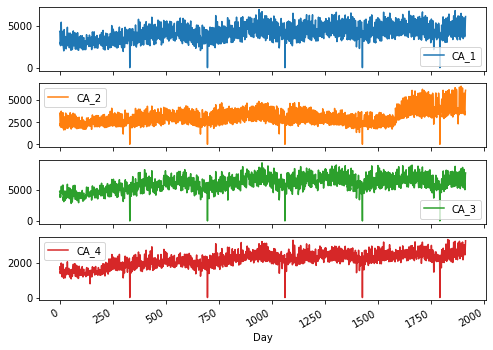

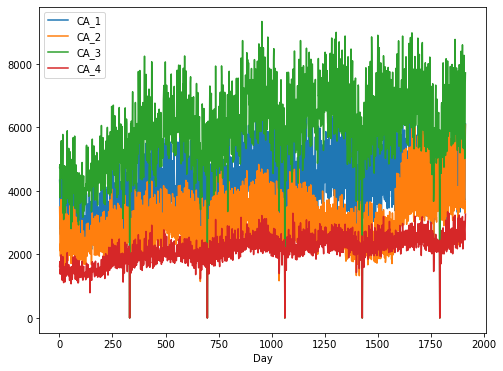

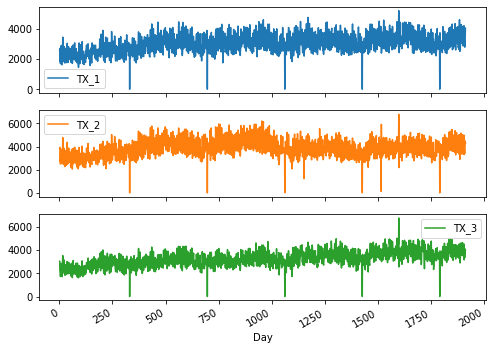

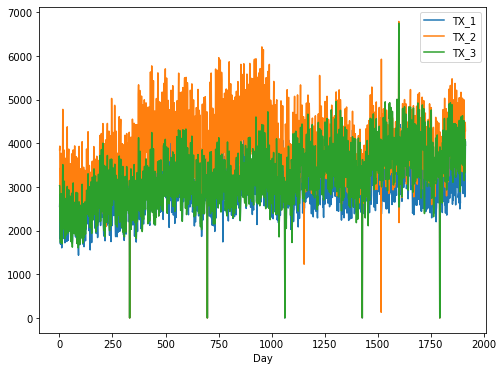

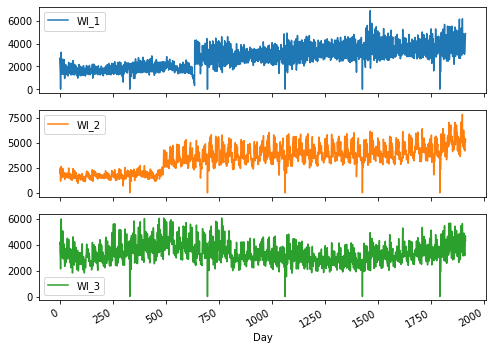

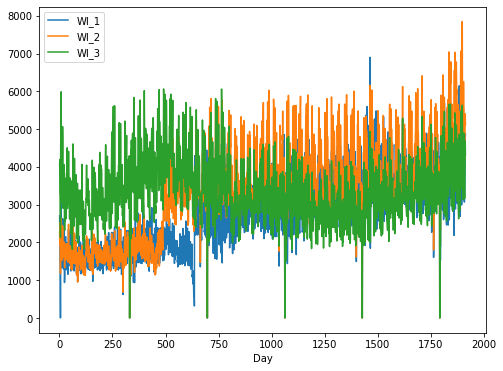

In [8]:
#Traverse through CA, TX and WI
for state in states:
  features_considered = []
  features = None
  
  #Append all the stores of a state in an array
  for i in features_dict[state]:
    features_considered.append(i)
  print(features_considered)

  #Get those stores columns from df1
  features = df1[features_considered]
  features.index = df1['Day']
  features = features.reindex(sorted(features.columns), axis=1)
  print(features.head())
  
  #Let's have a look at how each of these features vary across time
  features.plot(subplots=True)

  #Here they are plotted on one graph
  features.plot()

  #As mentioned, the first step will be to standardize the dataset 
      #using the mean and standard deviation of the training data
  
  #Define training and testing size
  TRAIN_SIZE = int(len(df1) * 0.9)
  test_size = len(df1) - TRAIN_SIZE
  TEST_DATASET = df1.iloc[TRAIN_SIZE:len(df1)]
  
  #Get mean and std deviation to standardize the dataset for that state
  dataset = features.values
  data_mean = dataset[:TRAIN_SIZE].mean(axis=0)
  print(data_mean)
  data_std = dataset[:TRAIN_SIZE].std(axis=0)
  print(data_std)
  dataset = (dataset-data_mean)/data_std

  state_mean = str("{}_mean").format(state)
  state_std = str("{}_std").format(state)

  #store the dataset, its mean and std in a dictionary
  dataset_dict[state] = dataset
  dataset_dict[state_mean] = data_mean
  dataset_dict[state_std] = data_std 

## **Single Step Model**

In [0]:
#This function returns the first N days of history data and the value N+1 as the label
#The size of the dataset will depend on the value of TRAIN_SIZE

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
#Plot the loss and validation function for the training data
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
#Now that the data has been created, let's take a look at a single example
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
#Plot history data, true future and our prediction
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [0]:
#Hyperparameters
past_history = 100
future_target = 20
STEP = 1
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS=100
EVALUATION_INTERVAL = 50
LEARNING_RATE_VALUE=0.05

Training for CA_3
Single window of past history : (100, 4)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 58ms/step - loss: 0.4985 - val_loss: 0.3943
Epoch 2/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3989 - val_loss: 0.4143
Epoch 3/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3636 - val_loss: 0.4031
Epoch 4/100
50/50 [==============================] - 3s 51ms/step - loss: 0.3600 - val_loss: 0.4506
Epoch 5/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3516 - val_loss: 0.4556
Epoch 6/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3478 - val_loss: 0.4386
Epoch 7/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3403 - val_loss: 0.4378
Epoch 8/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3372 - val_loss: 0.4663
Epoch 9/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3350 - val_loss: 0.4698
Epoch 10/100
50/50 [=============

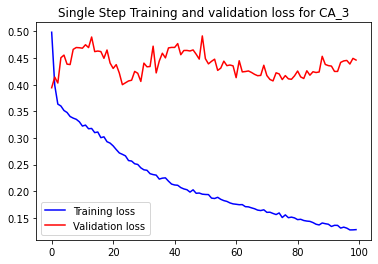

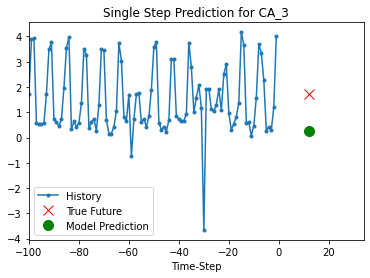

CA_3 - True Future: 7921
CA_3 - Model Prediction: 6138
CA_3 - Model Percentage Error: 22.51%
Training for CA_4
Single window of past history : (100, 4)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 56ms/step - loss: 0.4673 - val_loss: 0.4149
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3807 - val_loss: 0.3873
Epoch 3/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3618 - val_loss: 0.3760
Epoch 4/100
50/50 [==============================] - 3s 51ms/step - loss: 0.3600 - val_loss: 0.3737
Epoch 5/100
50/50 [==============================] - 3s 52ms/step - loss: 0.3529 - val_loss: 0.3700
Epoch 6/100
50/50 [==============================] - 3s 52ms/step - loss: 0.3528 - val_loss: 0.3742
Epoch 7/100
50/50 [==============================] - 3s 52ms/step - loss: 0.3456 - val_loss: 0.3719
Epoch 8/100
50/50 [==============================] - 3s 52ms/step - loss: 0.3442 - val_loss: 0.3775
Epoch 9/100
50/50 [=====================

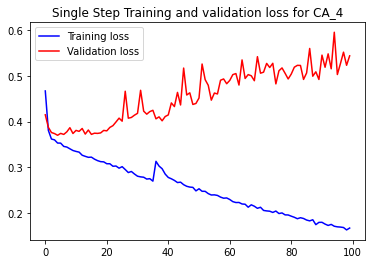

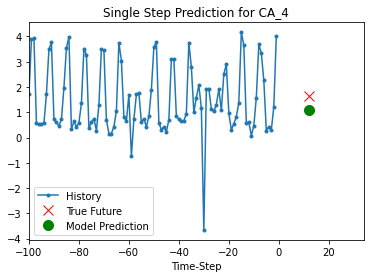

CA_4 - True Future: 2799
CA_4 - Model Prediction: 2561
CA_4 - Model Percentage Error: 8.50%
Training for CA_1
Single window of past history : (100, 4)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 55ms/step - loss: 0.5242 - val_loss: 0.4304
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3755 - val_loss: 0.4521
Epoch 3/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3479 - val_loss: 0.4779
Epoch 4/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3375 - val_loss: 0.4437
Epoch 5/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3383 - val_loss: 0.4369
Epoch 6/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3259 - val_loss: 0.4344
Epoch 7/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3253 - val_loss: 0.4321
Epoch 8/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3191 - val_loss: 0.4307
Epoch 9/100
50/50 [======================

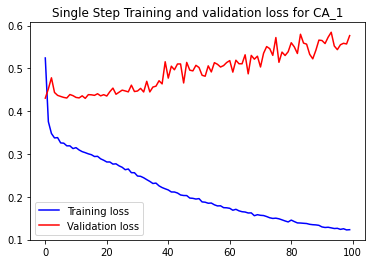

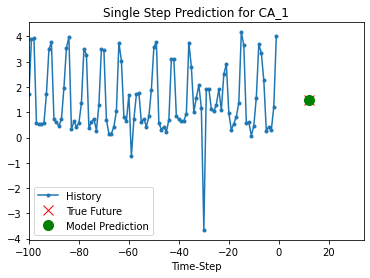

CA_1 - True Future: 5483
CA_1 - Model Prediction: 5477
CA_1 - Model Percentage Error: 0.11%
Training for CA_2
Single window of past history : (100, 4)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 57ms/step - loss: 0.5000 - val_loss: 0.6598
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3370 - val_loss: 0.6232
Epoch 3/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3273 - val_loss: 0.6151
Epoch 4/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3269 - val_loss: 0.6073
Epoch 5/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3197 - val_loss: 0.6088
Epoch 6/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3176 - val_loss: 0.5925
Epoch 7/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3129 - val_loss: 0.5742
Epoch 8/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3092 - val_loss: 0.5814
Epoch 9/100
50/50 [======================

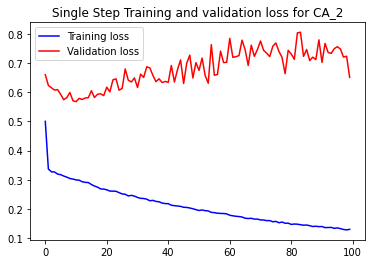

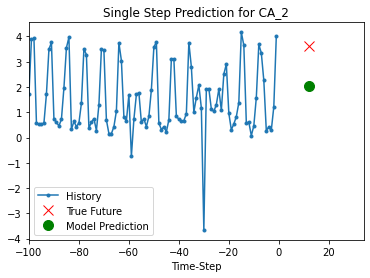

CA_2 - True Future: 5645
CA_2 - Model Prediction: 4435
CA_2 - Model Percentage Error: 21.43%
Training for TX_1
Single window of past history : (100, 3)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 57ms/step - loss: 0.5863 - val_loss: 0.4747
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4650 - val_loss: 0.3980
Epoch 3/100
50/50 [==============================] - 3s 51ms/step - loss: 0.4400 - val_loss: 0.4077
Epoch 4/100
50/50 [==============================] - 3s 50ms/step - loss: 0.4258 - val_loss: 0.4341
Epoch 5/100
50/50 [==============================] - 3s 50ms/step - loss: 0.4217 - val_loss: 0.4153
Epoch 6/100
50/50 [==============================] - 2s 50ms/step - loss: 0.4117 - val_loss: 0.4310
Epoch 7/100
50/50 [==============================] - 2s 50ms/step - loss: 0.4093 - val_loss: 0.4268
Epoch 8/100
50/50 [==============================] - 2s 50ms/step - loss: 0.4008 - val_loss: 0.4132
Epoch 9/100
50/50 [=====================

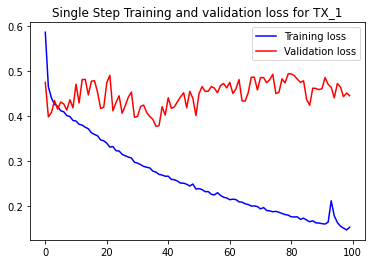

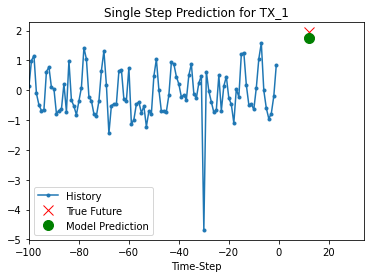

TX_1 - True Future: 4107
TX_1 - Model Prediction: 3988
TX_1 - Model Percentage Error: 2.90%
Training for TX_3
Single window of past history : (100, 3)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 63ms/step - loss: 0.5521 - val_loss: 0.4531
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4472 - val_loss: 0.4204
Epoch 3/100
50/50 [==============================] - 2s 48ms/step - loss: 0.4138 - val_loss: 0.4096
Epoch 4/100
50/50 [==============================] - 2s 48ms/step - loss: 0.4084 - val_loss: 0.4187
Epoch 5/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4043 - val_loss: 0.4073
Epoch 6/100
50/50 [==============================] - 2s 48ms/step - loss: 0.3951 - val_loss: 0.4714
Epoch 7/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3941 - val_loss: 0.4053
Epoch 8/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3888 - val_loss: 0.4066
Epoch 9/100
50/50 [======================

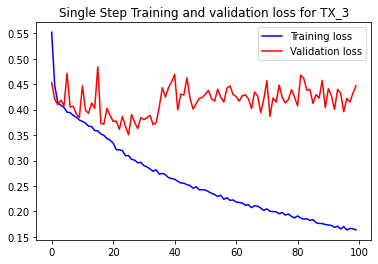

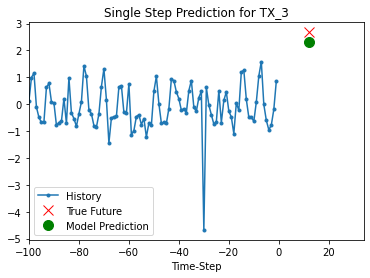

TX_3 - True Future: 4929
TX_3 - Model Prediction: 4682
TX_3 - Model Percentage Error: 5.01%
Training for TX_2
Single window of past history : (100, 3)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 56ms/step - loss: 0.5657 - val_loss: 0.4376
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4493 - val_loss: 0.4150
Epoch 3/100
50/50 [==============================] - 3s 62ms/step - loss: 0.4246 - val_loss: 0.4472
Epoch 4/100
50/50 [==============================] - 4s 78ms/step - loss: 0.4144 - val_loss: 0.4298
Epoch 5/100
50/50 [==============================] - 3s 50ms/step - loss: 0.4129 - val_loss: 0.4199
Epoch 6/100
50/50 [==============================] - 2s 50ms/step - loss: 0.4055 - val_loss: 0.4109
Epoch 7/100
50/50 [==============================] - 2s 48ms/step - loss: 0.4034 - val_loss: 0.4325
Epoch 8/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3982 - val_loss: 0.4241
Epoch 9/100
50/50 [======================

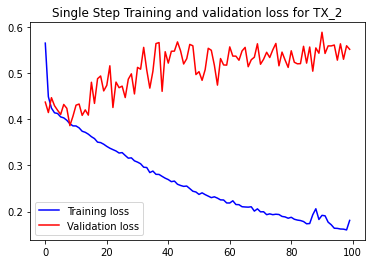

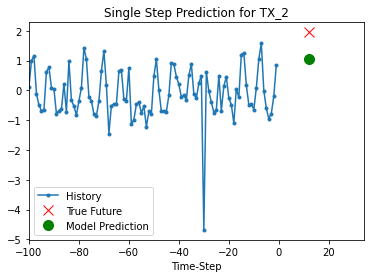

TX_2 - True Future: 5327
TX_2 - Model Prediction: 4601
TX_2 - Model Percentage Error: 13.63%
Training for WI_1
Single window of past history : (100, 3)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 56ms/step - loss: 0.4481 - val_loss: 0.4925
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3271 - val_loss: 0.4894
Epoch 3/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3145 - val_loss: 0.4453
Epoch 4/100
50/50 [==============================] - 2s 48ms/step - loss: 0.3056 - val_loss: 0.4209
Epoch 5/100
50/50 [==============================] - 2s 48ms/step - loss: 0.2979 - val_loss: 0.3913
Epoch 6/100
50/50 [==============================] - 2s 49ms/step - loss: 0.2941 - val_loss: 0.3918
Epoch 7/100
50/50 [==============================] - 2s 49ms/step - loss: 0.2877 - val_loss: 0.4018
Epoch 8/100
50/50 [==============================] - 2s 49ms/step - loss: 0.2881 - val_loss: 0.4162
Epoch 9/100
50/50 [=====================

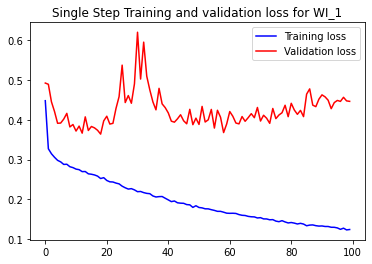

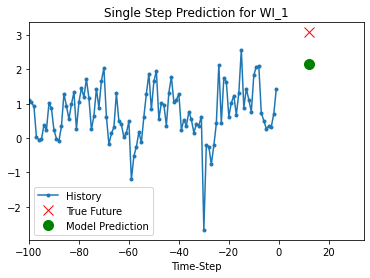

WI_1 - True Future: 5490
WI_1 - Model Prediction: 4629
WI_1 - Model Percentage Error: 15.68%
Training for WI_3
Single window of past history : (100, 3)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 56ms/step - loss: 0.6439 - val_loss: 0.5686
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4796 - val_loss: 0.6112
Epoch 3/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4400 - val_loss: 0.5111
Epoch 4/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4259 - val_loss: 0.6408
Epoch 5/100
50/50 [==============================] - 2s 49ms/step - loss: 0.4246 - val_loss: 0.6854
Epoch 6/100
50/50 [==============================] - 3s 50ms/step - loss: 0.4157 - val_loss: 0.6773
Epoch 7/100
50/50 [==============================] - 3s 50ms/step - loss: 0.4088 - val_loss: 0.7728
Epoch 8/100
50/50 [==============================] - 3s 50ms/step - loss: 0.4043 - val_loss: 0.7080
Epoch 9/100
50/50 [=====================

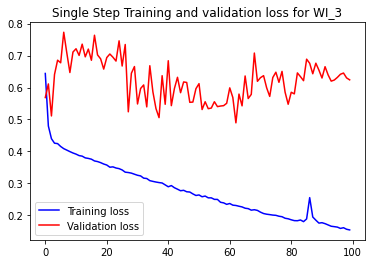

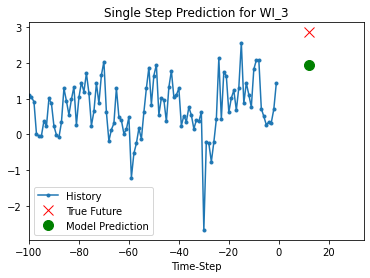

WI_3 - True Future: 5666
WI_3 - Model Prediction: 4910
WI_3 - Model Percentage Error: 13.34%
Training for WI_2
Single window of past history : (100, 3)
(72, 1)
Epoch 1/100
50/50 [==============================] - 3s 56ms/step - loss: 0.4558 - val_loss: 0.6947
Epoch 2/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3627 - val_loss: 0.7433
Epoch 3/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3308 - val_loss: 0.7727
Epoch 4/100
50/50 [==============================] - 2s 50ms/step - loss: 0.3303 - val_loss: 0.7624
Epoch 5/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3203 - val_loss: 0.7590
Epoch 6/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3166 - val_loss: 0.8070
Epoch 7/100
50/50 [==============================] - 2s 49ms/step - loss: 0.3115 - val_loss: 0.8857
Epoch 8/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3086 - val_loss: 0.8000
Epoch 9/100
50/50 [=====================

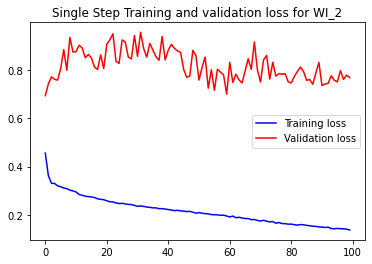

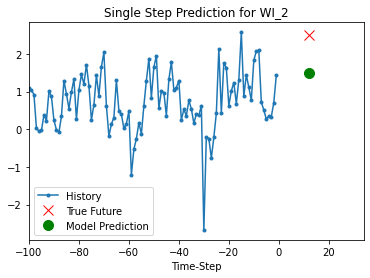

WI_2 - True Future: 6348
WI_2 - Model Prediction: 5110
WI_2 - Model Percentage Error: 19.50%


In [20]:
#Traverse through CA, TX and WI
for state in states:

    #Get all store id's (one by one) for each state
    for store_id in features_dict[state]:
      print("Training for {}".format(store_id))
      
      #The stores ids go from 1 to 4, but the indexes go from 0 to 3, we substract 1 from the id
      dictionary_index = int(store_id[-1])-1

      #Split training and validation data
      x_train_single, y_train_single = multivariate_data(dataset_dict[state], dataset_dict[state][:, dictionary_index], 0,
                                                        TRAIN_SIZE, past_history,
                                                        future_target, STEP,
                                                        single_step=True)
      x_val_single, y_val_single = multivariate_data(dataset_dict[state], dataset_dict[state][:, dictionary_index], TRAIN_SIZE,
                                                    None, past_history,
                                                    future_target, STEP,
                                                    single_step=True)
      
      print ('Single window of past history : {}'.format(x_train_single[0].shape))

      #Transform data to the form of a tensor and cache it in memory
      train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
      train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

      val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
      val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

      #Define Neural Network structure
      single_step_model = tf.keras.models.Sequential()
      single_step_model.add(tf.keras.layers.LSTM(32,input_shape=x_train_single.shape[-2:]))
      single_step_model.add(tf.keras.layers.Dense(1))

      #Compile Neural network 
      sgd = optimizers.SGD(learning_rate=LEARNING_RATE_VALUE, decay=1e-6, momentum=0.9, nesterov=True)
      single_step_model.compile(optimizer=sgd, loss='mae')

      #Check out a sample prediction
      for x, y in val_data_single.take(1):
        print(single_step_model.predict(x).shape)
      
      #Train the model and plot its validation and loss history
      single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                                  steps_per_epoch=EVALUATION_INTERVAL,
                                                  validation_data=val_data_single,
                                                  validation_steps=10)
      plot_train_history(single_step_history,'Single Step Training and validation loss for {}'.format(store_id))
      
      #Make sample predictions with trained model
      for x, y in val_data_single.take(1):
        plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                          single_step_model.predict(x)[0]], 12,
                        'Single Step Prediction for {}'.format(store_id))
        plot.show()

        state_mean = str("{}_mean").format(state)
        state_std = str("{}_std").format(state)
        true_future = int(y[0].numpy() * dataset_dict[state_std][dictionary_index] + dataset_dict[state_mean][dictionary_index])
        model_prediction = int(single_step_model.predict(x)[0] * dataset_dict[state_std][dictionary_index] + dataset_dict[state_mean][dictionary_index])        
        model_percentage_error = (abs(true_future - model_prediction) / true_future) * 100
        
        print('{} - True Future:'.format(store_id), true_future)
        print('{} - Model Prediction:'.format(store_id), model_prediction)
        print('{} - Model Percentage Error: {:0.2f}%'.format(store_id, model_percentage_error))
        print('====================================')
        print('====================================')
        


## **Multi-Step model**

In [0]:
#Plotting a sample data-point 
def multi_step_plot(history, true_future, prediction,title):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

def multi_step_plot_tail(history, true_future, prediction,title):
  plt.figure(figsize=(18, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.xlim([-10, 30])
  plt.show()

In [0]:
#Hyperparameters
past_history = 100
future_target = 20
STEP = 1
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS=100
EVALUATION_INTERVAL = 50
LEARNING_RATE_VALUE=0.05

Training for CA_3
Single window of past history : (100, 4)
(72, 20)
Epoch 1/100
50/50 [==============================] - 5s 100ms/step - loss: 0.7093 - val_loss: 0.6452
Epoch 2/100
50/50 [==============================] - 5s 91ms/step - loss: 0.6388 - val_loss: 0.6403
Epoch 3/100
50/50 [==============================] - 4s 88ms/step - loss: 0.6167 - val_loss: 0.6396
Epoch 4/100
50/50 [==============================] - 4s 87ms/step - loss: 0.6120 - val_loss: 0.6361
Epoch 5/100
50/50 [==============================] - 4s 87ms/step - loss: 0.6068 - val_loss: 0.6302
Epoch 6/100
50/50 [==============================] - 4s 85ms/step - loss: 0.5991 - val_loss: 0.6205
Epoch 7/100
50/50 [==============================] - 4s 86ms/step - loss: 0.5813 - val_loss: 0.5809
Epoch 8/100
50/50 [==============================] - 4s 86ms/step - loss: 0.5084 - val_loss: 0.4192
Epoch 9/100
50/50 [==============================] - 4s 87ms/step - loss: 0.4334 - val_loss: 0.4055
Epoch 10/100
50/50 [===========

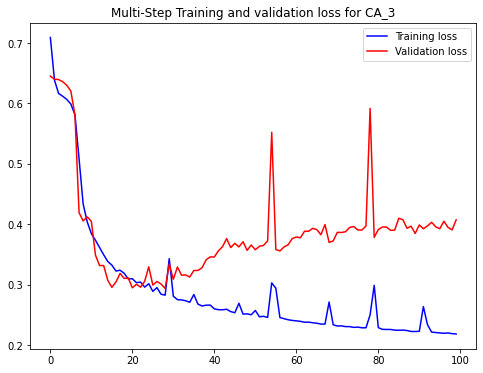

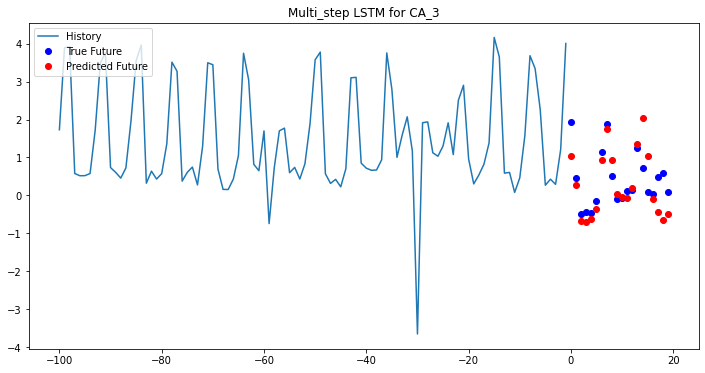

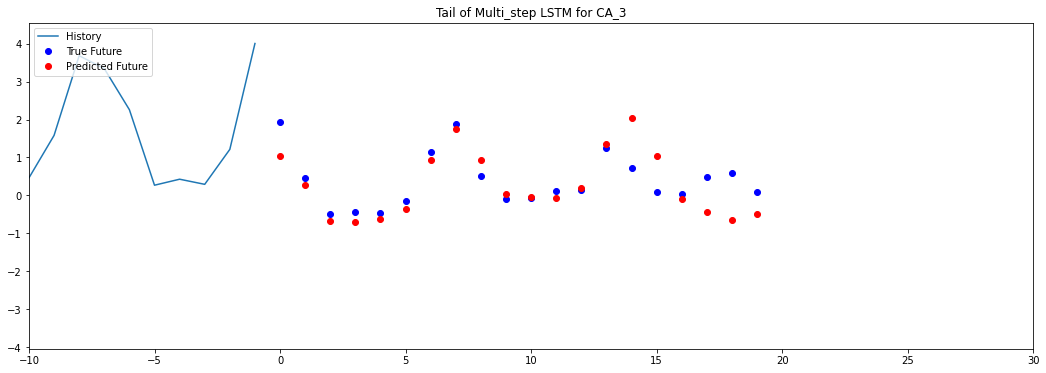

CA_3 - True Future: [8164. 6371. 5244. 5309. 5261. 5637. 7217. 8094. 6446. 5722. 5740. 5951.
 5986. 7347. 6696. 5930. 5882. 6421. 6547. 5928.]
CA_3 - Model Prediction: [7087.573  6142.6094 5020.207  4967.9395 5056.548  5400.1113 6948.494
 7929.902  6961.2837 5877.0005 5783.3228 5752.906  6047.0713 7470.073
 8284.079  7076.125  5702.285  5291.16   5046.4517 5246.501 ]
CA_3 - Model Percentage Error: [13.18504113  3.58484736  4.26760047  6.42419565  3.88618416  4.20238907
  3.72046362  2.0274048   7.99385187  2.7088516   0.75475181  3.32875547
  1.02023537  1.67514961 23.71683246 19.32757167  3.05533566 17.59601065
 22.9196325  11.49627233]%
CA_3 - Model Mean Percentage Error: 7.844568862317521%
Training for CA_1
Single window of past history : (100, 4)
(72, 20)
Epoch 1/100
50/50 [==============================] - 5s 94ms/step - loss: 0.7591 - val_loss: 0.7256
Epoch 2/100
50/50 [==============================] - 4s 85ms/step - loss: 0.7055 - val_loss: 0.7291
Epoch 3/100
50/50 [===========

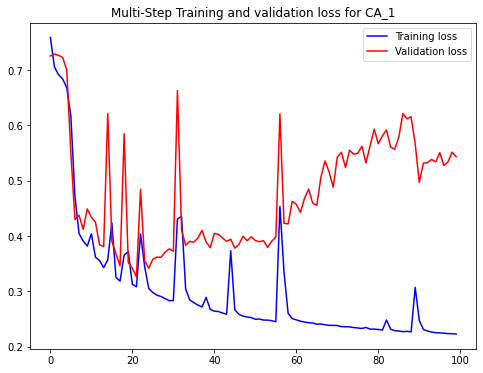

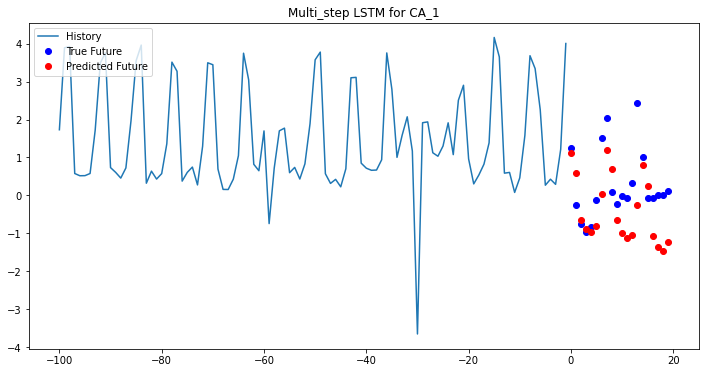

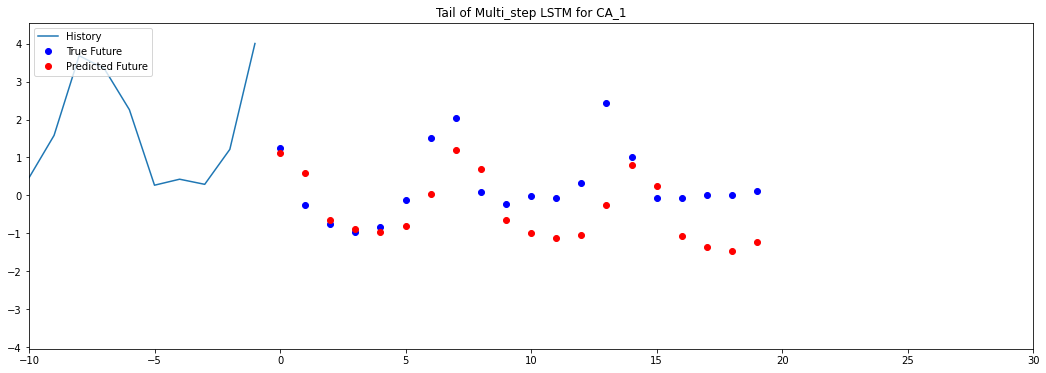

CA_1 - True Future: [5247. 3741. 3246. 3031. 3173. 3871. 5498. 6032. 4075. 3765. 3983. 3928.
 4327. 6412. 4986. 3933. 3936. 3995. 4007. 4111.]
CA_1 - Model Prediction: [5092.447  4590.7173 3359.8135 3110.2654 3040.8809 3191.6877 4028.5652
 5188.2715 4675.2974 3355.1396 3001.8667 2873.1113 2945.0942 3737.7087
 4795.9727 4249.328  2922.5552 2645.8167 2541.655  2765.3252]
CA_1 - Model Percentage Error: [ 2.94555408 22.71364034  3.50626853  2.61515608  4.16385568 17.5487537
 26.72671543 13.9875417  14.73122364 10.88606511 24.63302287 26.85561792
 31.93680984 41.70759919  3.81121829  8.04292207 25.74809005 33.77179849
 36.56962742 32.73351507]%
CA_1 - Model Mean Percentage Error: 19.281749775084712%
Training for CA_2
Single window of past history : (100, 4)
(72, 20)
Epoch 1/100
50/50 [==============================] - 5s 93ms/step - loss: 0.7526 - val_loss: 1.7941
Epoch 2/100
50/50 [==============================] - 4s 87ms/step - loss: 0.7007 - val_loss: 1.2817
Epoch 3/100
50/50 [=========

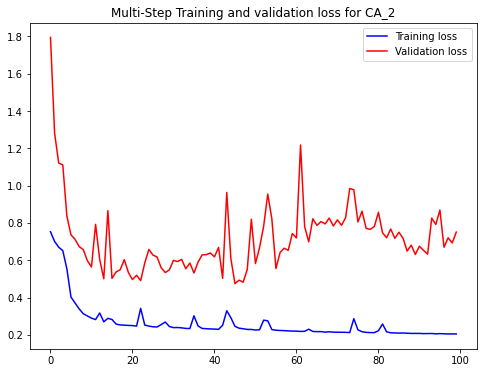

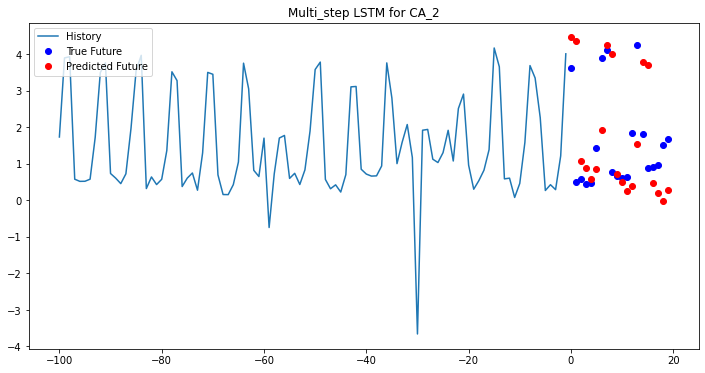

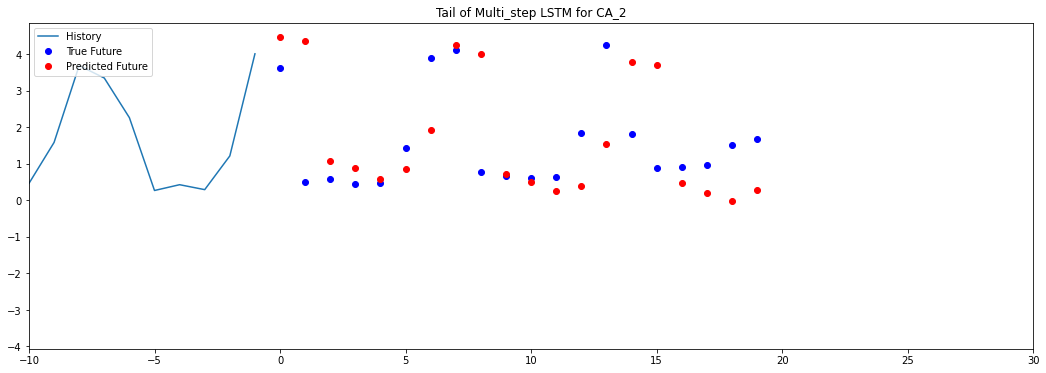

CA_2 - True Future: [5647. 3240. 3294. 3189. 3211. 3964. 5873. 6037. 3454. 3360. 3314. 3333.
 4276. 6150. 4251. 3537. 3549. 3586. 4026. 4140.]
CA_2 - Model Prediction: [6304.6455 6236.5034 3688.329  3530.7961 3289.4517 3514.6204 4342.9624
 6141.742  5963.677  3406.1328 3242.7944 3038.433  3139.6338 4039.8882
 5786.42   5713.849  3217.1555 2995.8906 2831.2104 3069.823 ]
CA_2 - Model Percentage Error: [11.64592718 92.48467339 11.97113241 10.71797249  2.44321583 11.33651964
 26.05206194  1.73500393 72.66001036  1.37300037  2.14862904  8.83789062
 26.57544927 34.31076124 36.11902898 61.54506986  9.35036581 16.45592234
 29.67683931 25.84968604]%
CA_2 - Model Mean Percentage Error: 24.664458002970495%
Training for CA_4
Single window of past history : (100, 4)
(72, 20)
Epoch 1/100
50/50 [==============================] - 5s 93ms/step - loss: 0.6749 - val_loss: 0.7017
Epoch 2/100
50/50 [==============================] - 4s 85ms/step - loss: 0.5246 - val_loss: 0.5785
Epoch 3/100
50/50 [========

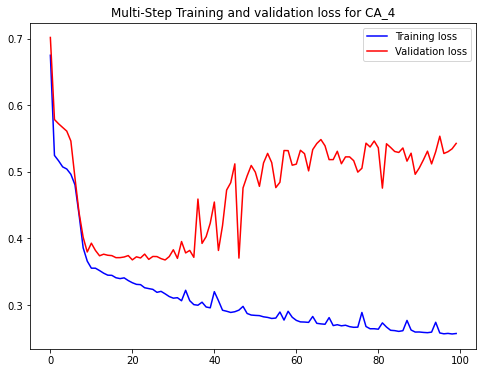

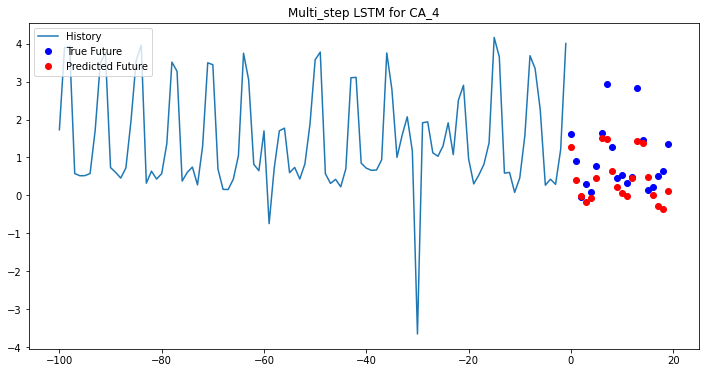

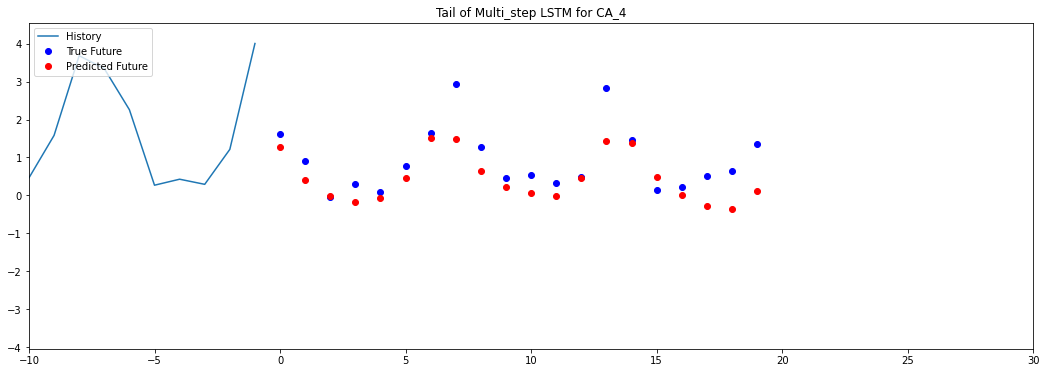

CA_4 - True Future: [2787. 2487. 2088. 2239. 2153. 2432. 2806. 3343. 2643. 2299. 2335. 2244.
 2316. 3301. 2727. 2166. 2207. 2323. 2383. 2677.]
CA_4 - Model Prediction: [2647.6494 2286.0676 2102.956  2041.497  2083.5317 2303.9011 2745.3696
 2740.4104 2378.5562 2202.6309 2133.2295 2106.695  2299.6428 2715.9458
 2686.7146 2310.5208 2112.4604 1994.9177 1957.0785 2156.0312]
CA_4 - Model Percentage Error: [ 5.00002102  8.07930732  0.71628614  8.82103849  3.22657974  5.26722356
  2.16074024 18.02541429 10.00544259  4.19178515  8.64113524  6.11875809
  0.70626847 17.72354436  1.47727908  6.67224155  4.2836226  14.12321461
 17.8733323  19.46091707]%
CA_4 - Model Mean Percentage Error: 8.128707595284672%
Training for TX_3
Single window of past history : (100, 3)
(72, 20)
Epoch 1/100
50/50 [==============================] - 4s 89ms/step - loss: 0.7300 - val_loss: 1.0228
Epoch 2/100
50/50 [==============================] - 4s 82ms/step - loss: 0.6686 - val_loss: 0.8379
Epoch 3/100
50/50 [=========

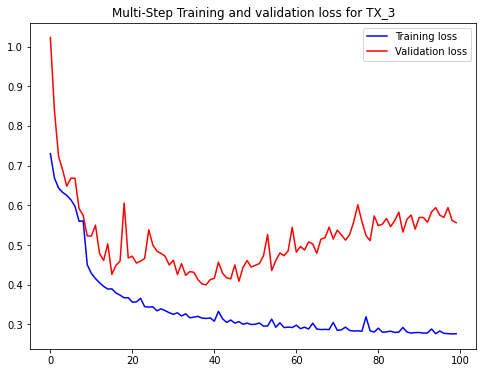

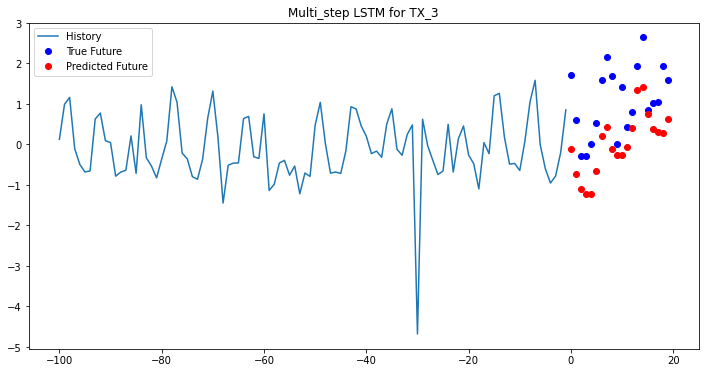

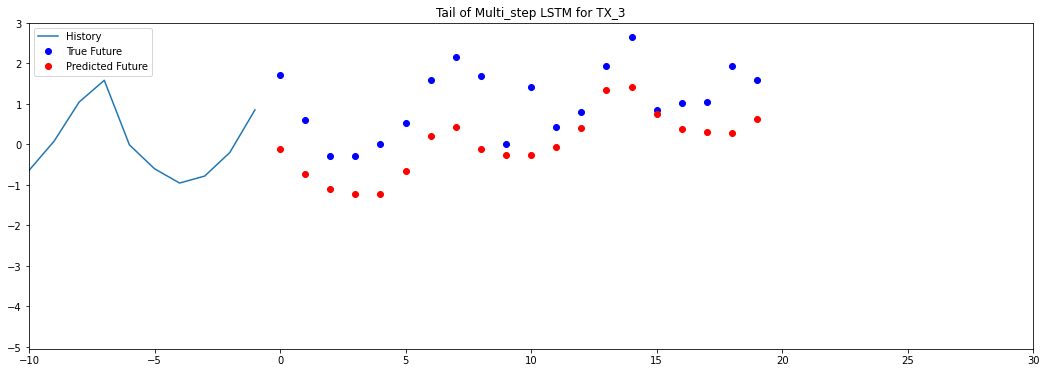

TX_3 - True Future: [4286. 3538. 2934. 2939. 3135. 3486. 4202. 4575. 4262. 3141. 4091. 3421.
 3664. 4432. 4905. 3707. 3825. 3831. 4438. 4198.]
TX_3 - Model Prediction: [3056.7905 2633.4373 2390.121  2300.1736 2310.3184 2681.668  3275.502
 3418.8042 3054.8533 2959.0615 2957.7942 3090.6643 3396.9893 4036.4202
 4087.901  3641.6604 3393.8723 3330.442  3326.04   3553.0942]
TX_3 - Model Percentage Error: [28.67964239 25.56706456 18.53711337 21.73618292 26.30563447 23.07320801
 22.04897779 25.27203936 28.32348026  5.79237429 27.69997093  9.65611498
  7.28741109  8.92553777 16.6584938   1.76260048 11.27131204 13.06599075
 25.05542949 15.36221443]%
TX_3 - Model Mean Percentage Error: 18.10403965830141%
Training for TX_1
Single window of past history : (100, 3)
(72, 20)
Epoch 1/100
50/50 [==============================] - 4s 87ms/step - loss: 0.7371 - val_loss: 0.7534
Epoch 2/100
50/50 [==============================] - 4s 82ms/step - loss: 0.7109 - val_loss: 0.7293
Epoch 3/100
50/50 [==========

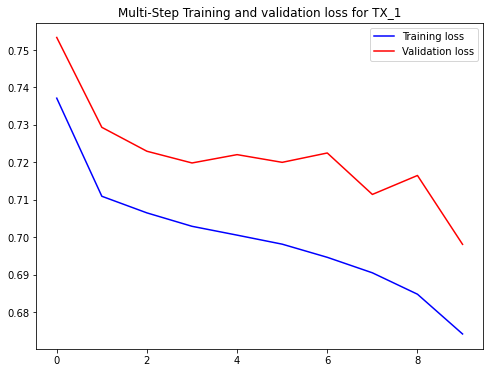

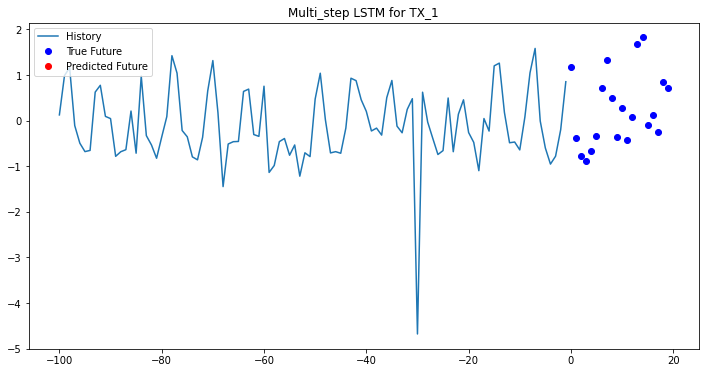

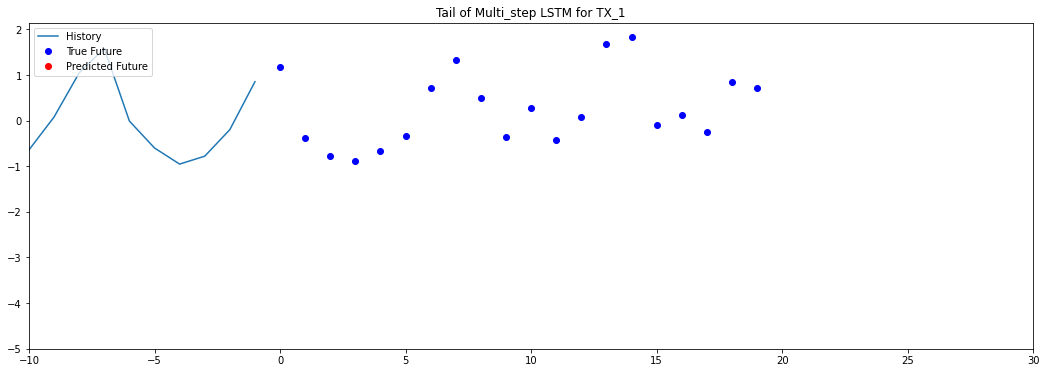

TX_1 - True Future: [3639. 2666. 2426. 2357. 2497. 2693. 3347. 3727. 3213. 2681. 3081. 2645.
 2949. 3939. 4034. 2845. 2978. 2745. 3431. 3343.]
TX_1 - Model Prediction: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
TX_1 - Model Percentage Error: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]%
TX_1 - Model Mean Percentage Error: nan%
Training for TX_2
Single window of past history : (100, 3)
(72, 20)
Epoch 1/100
50/50 [==============================] - 5s 95ms/step - loss: 0.7676 - val_loss: 0.6992
Epoch 2/100
50/50 [==============================] - 4s 79ms/step - loss: 0.7609 - val_loss: 0.7071
Epoch 3/100
50/50 [==============================] - 4s 77ms/step - loss: 0.7439 - val_loss: 0.7019
Epoch 4/100
50/50 [==============================] - 4s 80ms/step - loss: 0.7037 - val_loss: 0.7080
Epoch 5/100
50/50 [==============================] - 4s 77ms/step - loss: 0.6904 - val_loss: 0.7186
Epoch 6/100
50/50 [======

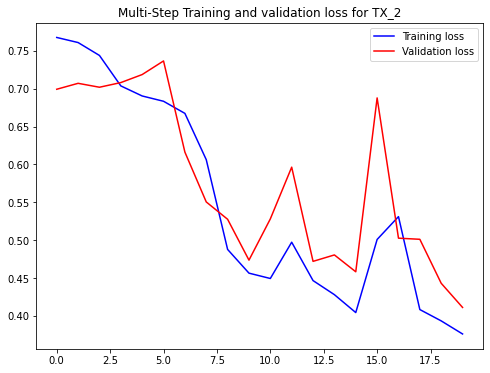

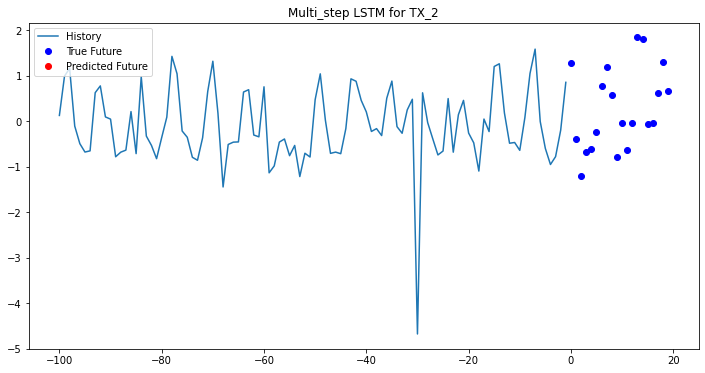

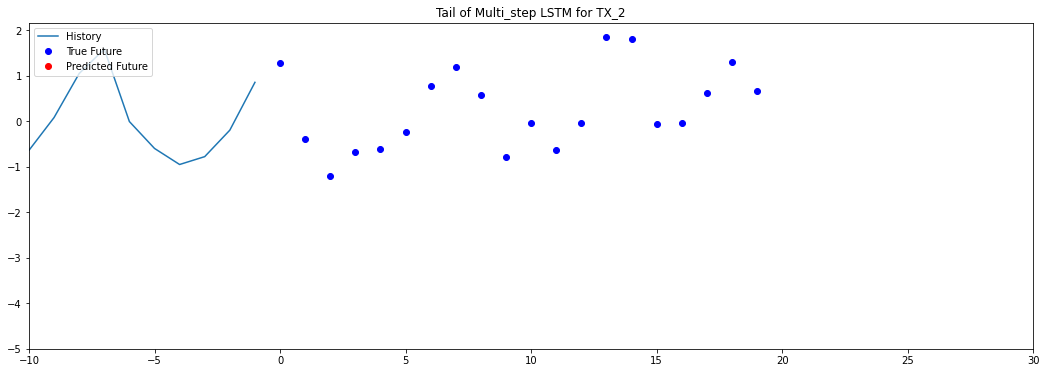

TX_2 - True Future: [4794. 3441. 2798. 3216. 3264. 3562. 4384. 4712. 4225. 3121. 3722. 3245.
 3737. 5240. 5210. 3714. 3737. 4259. 4799. 4295.]
TX_2 - Model Prediction: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
TX_2 - Model Percentage Error: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]%
TX_2 - Model Mean Percentage Error: nan%
Training for WI_2
Single window of past history : (100, 3)
(72, 20)
Epoch 1/100
50/50 [==============================] - 4s 85ms/step - loss: 0.7441 - val_loss: 1.4391
Epoch 2/100
50/50 [==============================] - 4s 77ms/step - loss: 0.4997 - val_loss: 1.1117
Epoch 3/100
50/50 [==============================] - 4s 78ms/step - loss: 0.4610 - val_loss: 1.1074
Epoch 4/100
50/50 [==============================] - 4s 77ms/step - loss: 0.4252 - val_loss: 1.0363
Epoch 5/100
50/50 [==============================] - 4s 78ms/step - loss: 0.3958 - val_loss: 1.0094
Epoch 6/100
50/50 [======

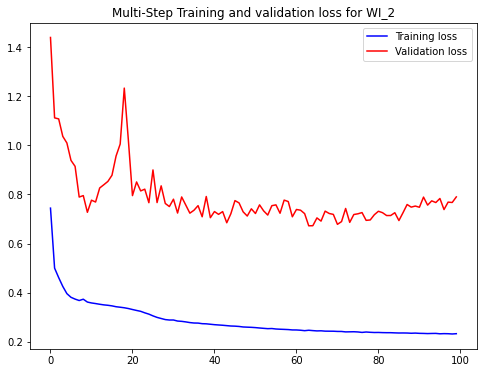

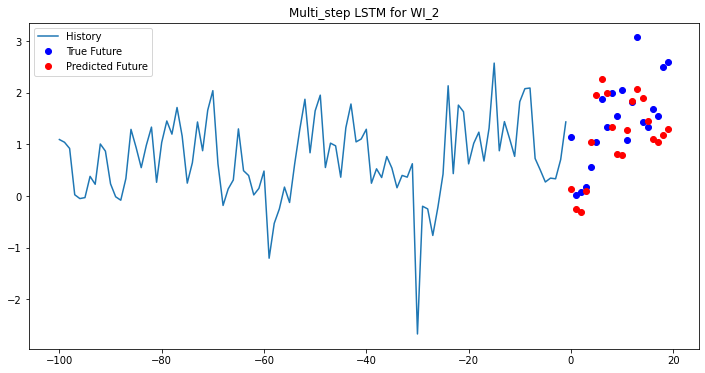

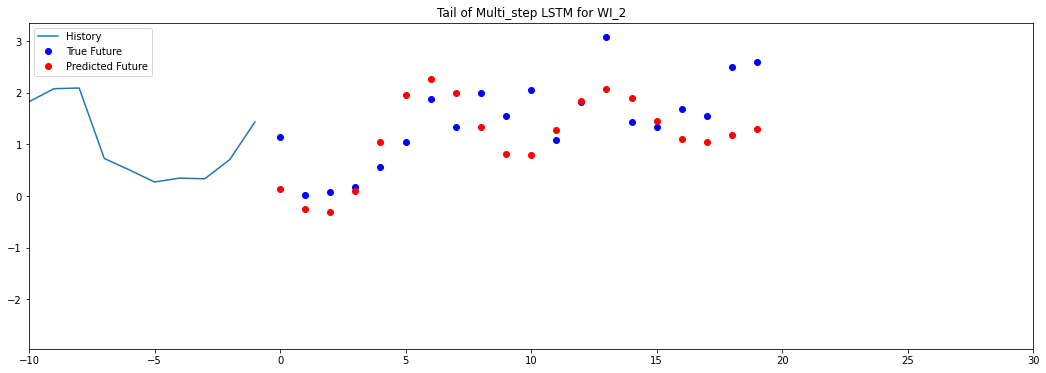

WI_2 - True Future: [4670. 3301. 3386. 3500. 3961. 4569. 5586. 4915. 5718. 5169. 5786. 4607.
 5506. 7046. 5046. 4907. 5358. 5180. 6333. 6463.]
WI_2 - Model Prediction: [3445.84   2966.185  2895.2686 3405.3486 4559.29   5683.4746 6061.3027
 5731.002  4916.35   4279.024  4256.5137 4837.264  5534.173  5827.7017
 5619.206  5066.529  4622.778  4565.0537 4721.842  4879.755 ]
WI_2 - Model Percentage Error: [26.21327435 10.14283373 14.49295468  2.70432478 15.10452005 24.39209038
  8.50882088 16.60227778 14.01976045 17.2175677  26.43426077  4.99813675
  0.51167547 17.29063781 11.35961266  3.25104562 13.72195162 11.87154998
 25.44067903 24.497062  ]%
WI_2 - Model Mean Percentage Error: 14.438751824124811%
Training for WI_3
Single window of past history : (100, 3)
(72, 20)
Epoch 1/100
50/50 [==============================] - 5s 91ms/step - loss: 0.7785 - val_loss: 1.1124
Epoch 2/100
50/50 [==============================] - 4s 83ms/step - loss: 0.7499 - val_loss: 1.0351
Epoch 3/100
50/50 [========

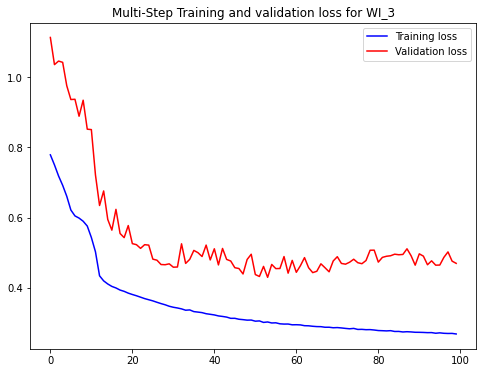

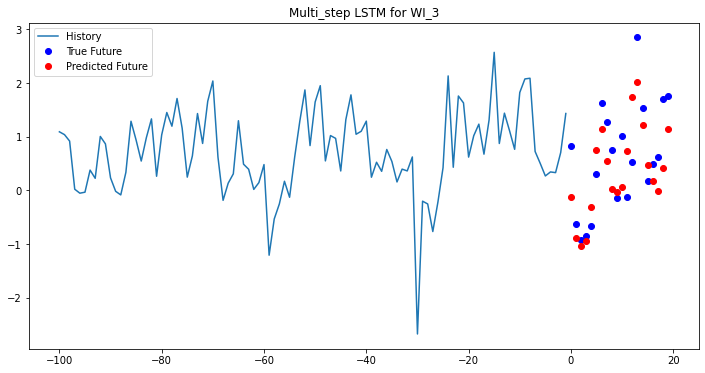

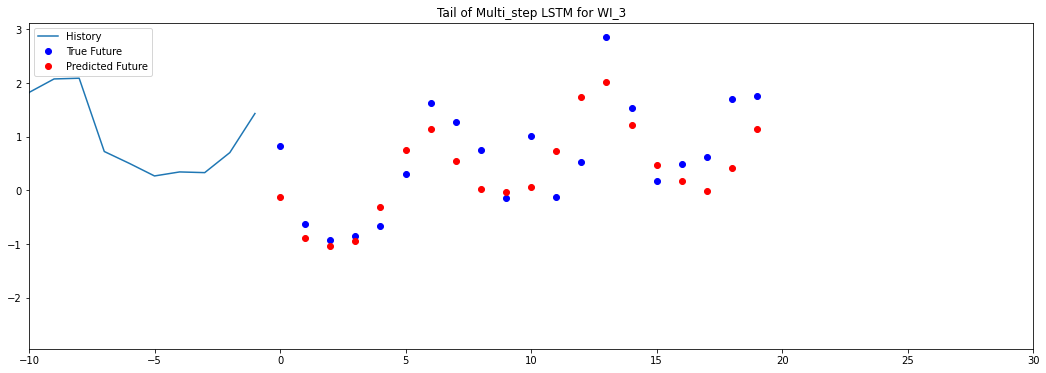

WI_3 - True Future: [3998. 2806. 2564. 2632. 2775. 3580. 4653. 4362. 3938. 3210. 4153. 3219.
 3756. 5657. 4577. 3468. 3728. 3833. 4721. 4759.]
WI_3 - Model Prediction: [3226.1172 2591.908  2478.9941 2551.584  3068.5796 3941.3704 4259.7563
 3771.186  3345.494  3296.5417 3376.0159 3921.414  4741.263  4971.3154
 4327.605  3710.4963 3461.1382 3319.504  3671.5422 4265.852 ]
WI_3 - Model Percentage Error: [19.30672367  7.62979476  3.31536113  3.05531974 10.57944468 10.09414417
  8.45140022 13.54456591 15.04586347  2.69600461 18.70898461 21.82087799
 26.23171415 12.12099293  5.44887524  6.99239729  7.15831053 13.3967152
 22.229565   10.36242801]%
WI_3 - Model Mean Percentage Error: 11.909474166305786%
Training for WI_1
Single window of past history : (100, 3)
(72, 20)
Epoch 1/100
50/50 [==============================] - 4s 88ms/step - loss: 0.6488 - val_loss: 0.9032
Epoch 2/100
50/50 [==============================] - 4s 79ms/step - loss: 0.5049 - val_loss: 0.8655
Epoch 3/100
50/50 [=========

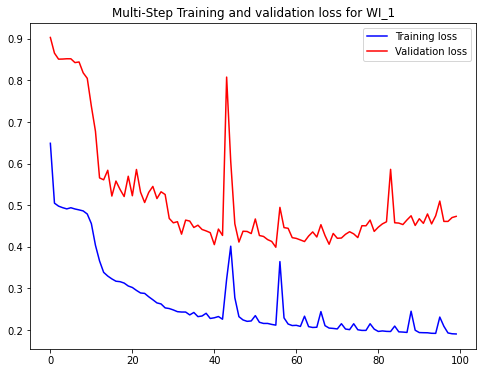

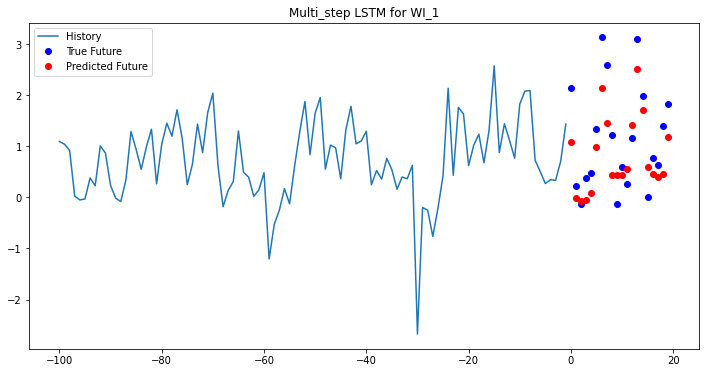

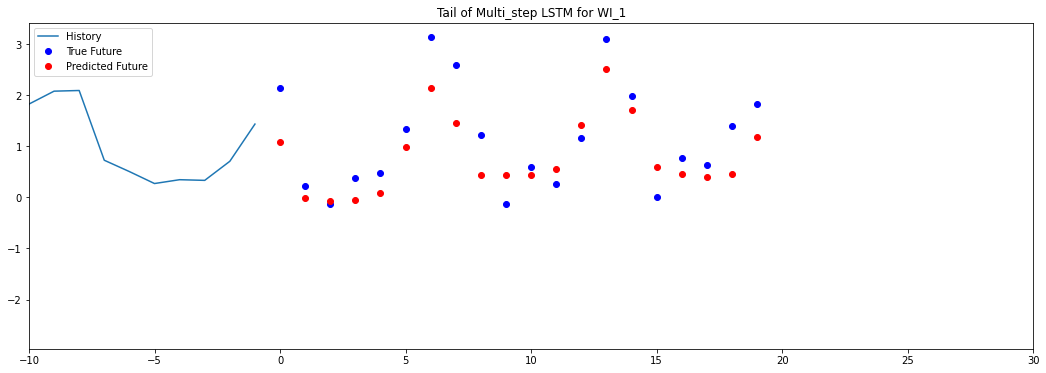

WI_1 - True Future: [4600. 2798. 2466. 2937. 3036. 3845. 5538. 5034. 3740. 2460. 3135. 2831.
 3676. 5516. 4461. 2597. 3313. 3180. 3899. 4308.]
WI_1 - Model Prediction: [3600.2405 2567.7883 2519.068  2535.0703 2665.9294 3519.6733 4606.1714
 3949.0742 2996.4421 2989.37   3000.7363 3112.3499 3913.5225 4949.092
 4198.9585 3151.9246 3013.3748 2956.8809 3010.1223 3695.5103]
WI_1 - Model Percentage Error: [21.73390264  8.2277223   2.1519917  13.68504213 12.18941227  8.46103147
 16.82608547 21.55196228 19.88122624 21.51911045  4.28273276  9.93817921
  6.461438   10.27752362  5.87405299 21.36790761  9.04392527  7.01632518
 22.79758106 14.21749643]%
WI_1 - Model Mean Percentage Error: 12.875232454359846%


In [15]:
'''In a multi-step prediction model, given a past history, 
    the model needs to learn to predict a range of future values.
    Thus, unlike a single step model, where only a single future 
    point is predicted, a multi-step model predict a sequence of 
    the future.'''

#Traverse through CA, TX and WI
for state in states:

    #Get all store id's (one by one) for each state
    for store_id in features_dict[state]:
      print("Training for {}".format(store_id))
      
      #The stores ids go from 1 to 4, but the indexes go from 0 to 3, we substract 1 from the id
      dictionary_index = int(store_id[-1])-1 

      #Split training and validation data
      x_train_multi, y_train_multi = multivariate_data(dataset_dict[state], dataset_dict[state][:, dictionary_index], 0,
                                                        TRAIN_SIZE, past_history,
                                                        future_target, STEP)
      x_val_multi, y_val_multi = multivariate_data(dataset_dict[state], dataset_dict[state][:, dictionary_index], TRAIN_SIZE,
                                                    None, past_history,
                                                    future_target, STEP)
      
      print ('Single window of past history : {}'.format(x_train_multi[0].shape))

      #Transform data to the form of a tensor and cache it in memory
      train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
      train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

      val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
      val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

      # we will want to stretch the plot to see the trend between each future step

      #Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers
      multi_step_model = tf.keras.models.Sequential()
      multi_step_model.add(tf.keras.layers.LSTM(32,
                                                return_sequences=True,
                                                input_shape=x_train_multi.shape[-2:]))
      multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
      multi_step_model.add(tf.keras.layers.Dense(20))

      #Compile Neural network 
      sgd = optimizers.SGD(learning_rate=LEARNING_RATE_VALUE, decay=1e-6, momentum=0.9, nesterov=True)
      multi_step_model.compile(optimizer=sgd, loss='mae')

      #Check out a sample prediction
      for x, y in val_data_multi.take(1):
        print(multi_step_model.predict(x).shape)
      
      #Train the model and plot its validation and loss history
      multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10)
      
      plot_train_history(multi_step_history, 'Multi-Step Training and validation loss for {}'.format(store_id))

      #Predict a multi-step future
      for x, y in val_data_multi.take(1):
        multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0],"Multi_step LSTM for {}".format(store_id))
        '''Zoom into tail of plot for better visualisation'''
        multi_step_plot_tail(x[0], y[0], multi_step_model.predict(x)[0],"Tail of Multi_step LSTM for {}".format(store_id))

        state_mean = str("{}_mean").format(state)
        state_std = str("{}_std").format(state)
 
        true_future = y[0].numpy() * dataset_dict[state_std][dictionary_index] + dataset_dict[state_mean][dictionary_index]
        model_prediction = multi_step_model.predict(x)[0] *  dataset_dict[state_std][dictionary_index] + dataset_dict[state_mean][dictionary_index]
        model_percentage_error = (abs(true_future - model_prediction) / true_future) * 100
        model_mean_percentage_error = sum(model_percentage_error) / len(model_percentage_error)

        print('{} - True Future:'.format(store_id), true_future)
        print('{} - Model Prediction:'.format(store_id), model_prediction)
        print('{} - Model Percentage Error: {}%'.format(store_id, model_percentage_error))
        print('{} - Model Mean Percentage Error: {}%'.format(store_id, model_mean_percentage_error))
        print('====================================')
        print('====================================')

